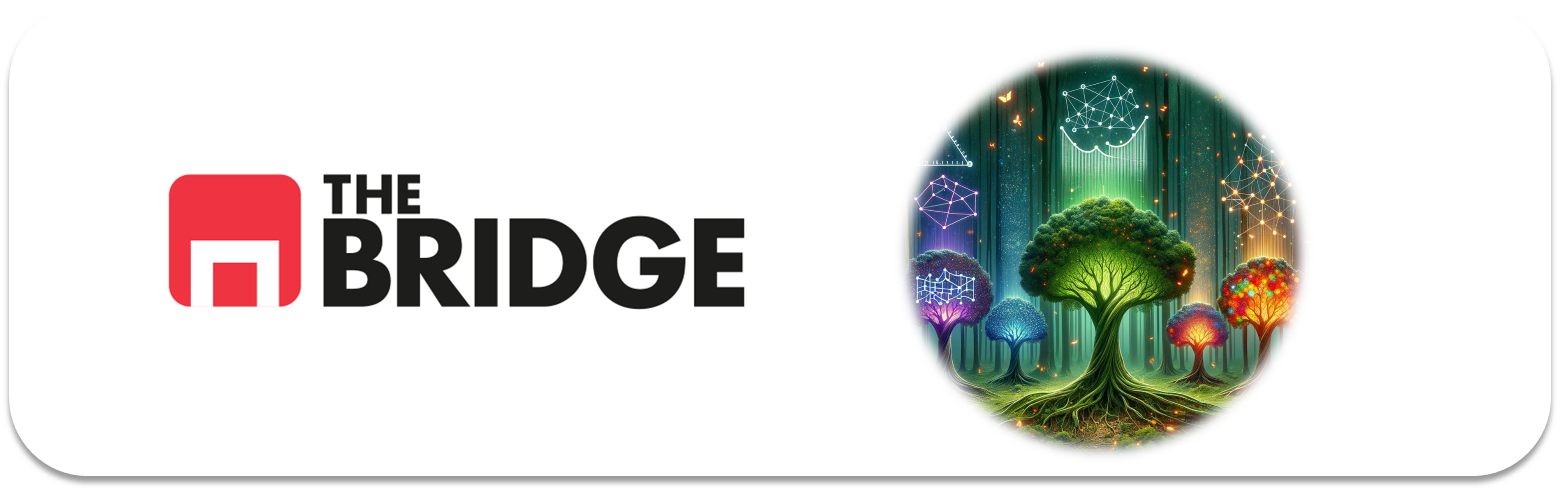

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [148]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
import numpy as np
import sklearn
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import pearsonr
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree


# Configurar pandas para mostrar todas las filas y columnas
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# para que la salida de este notebook sea estable en todas las ejecuciones
np.random.seed(42)

# Pintar
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [29]:
bank = pd.read_csv('./data/bank-full.csv', sep = ";")
bank.head(100)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,36,management,married,tertiary,no,101,yes,yes,unknown,5,may,426,1,-1,0,unknown,no
96,55,blue-collar,married,secondary,no,383,no,no,unknown,5,may,287,1,-1,0,unknown,no
97,60,retired,married,tertiary,no,81,yes,no,unknown,5,may,101,1,-1,0,unknown,no
98,39,technician,married,secondary,no,0,yes,no,unknown,5,may,203,1,-1,0,unknown,no


In [13]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Esta totalmente limpio.

Ahora voy a escoger la variable target, que si indagamos un poco vemos que es la ultima columna "y" donde normalmente pondria "deposit".

A continuacion el miniEDA:

Para ello voy a usar un heatmap y ver con qué tiene sentido hacer el modelo.

Antes busco las numericas, luego hare one-hot encoding con las categoricas.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>,
        <Axes: title={'center': 'day'}>],
       [<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'campaign'}>,
        <Axes: title={'center': 'pdays'}>],
       [<Axes: title={'center': 'previous'}>, <Axes: >, <Axes: >]],
      dtype=object)

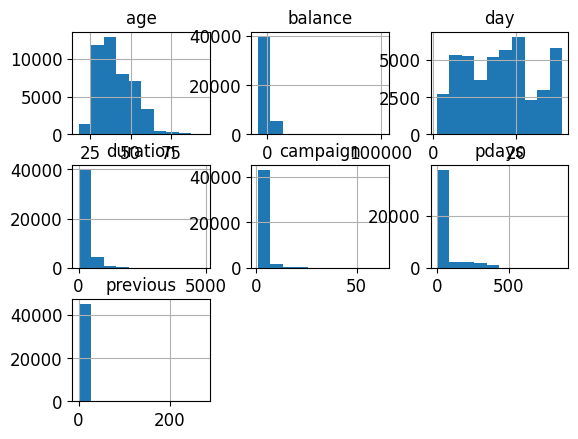

In [32]:
bank.hist()

codifico a 0 y 1 las de yes or no y el resto one-hot encoder.

In [43]:
binary_col = ['default', 'housing', 'loan', 'y']
dict = {'yes':1, 'no':0}

for col in binary_col:
    binary = bank[col].map(dict)
    bank[col] = binary


In [44]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


Codifico las que me quedan con al estilo One-hot.

In [46]:
bank_encoded = bank.copy()
bank_encoded = pd.get_dummies(bank_encoded, dtype= int, columns=["job", "marital", "education","contact","month","poutcome"])
bank_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  int64
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  int64
 4   loan                 45211 non-null  int64
 5   day                  45211 non-null  int64
 6   duration             45211 non-null  int64
 7   campaign             45211 non-null  int64
 8   pdays                45211 non-null  int64
 9   previous             45211 non-null  int64
 10  y                    45211 non-null  int64
 11  job_admin.           45211 non-null  int64
 12  job_blue-collar      45211 non-null  int64
 13  job_entrepreneur     45211 non-null  int64
 14  job_housemaid        45211 non-null  int64
 15  job_management       45211 non-null  int64
 16  job_retired          4

Ahora voy a hacer el split

In [50]:
train_set, test_set = train_test_split(bank_encoded, test_size= 0.2, random_state= 42)

In [51]:
X_train = train_set.drop(columns= ['y'])
y_train = train_set['y']

X_test = test_set.drop(columns = ['y'])
y_test = test_set['y']

Ahora vamos a analizar las correlaciones

In [56]:
corr = np.abs(train_set.corr(numeric_only=True)["y"].sort_values(ascending = False))
corr

y                      1.000000
duration               0.393402
poutcome_success       0.305084
contact_cellular       0.136622
month_oct              0.130183
month_mar              0.127642
month_sep              0.124370
pdays                  0.105742
previous               0.092051
month_dec              0.077569
job_retired            0.076440
job_student            0.073606
month_apr              0.071153
education_tertiary     0.065868
marital_single         0.061856
balance                0.052518
poutcome_other         0.035207
month_feb              0.031607
job_management         0.030974
age                    0.026684
job_unemployed         0.023566
contact_telephone      0.017208
poutcome_failure       0.011747
education_unknown      0.007343
job_admin.             0.004291
marital_divorced       0.004099
job_self-employed      0.004072
job_unknown            0.001127
month_aug              0.006371
month_jan              0.009773
job_technician         0.010275
job_hous

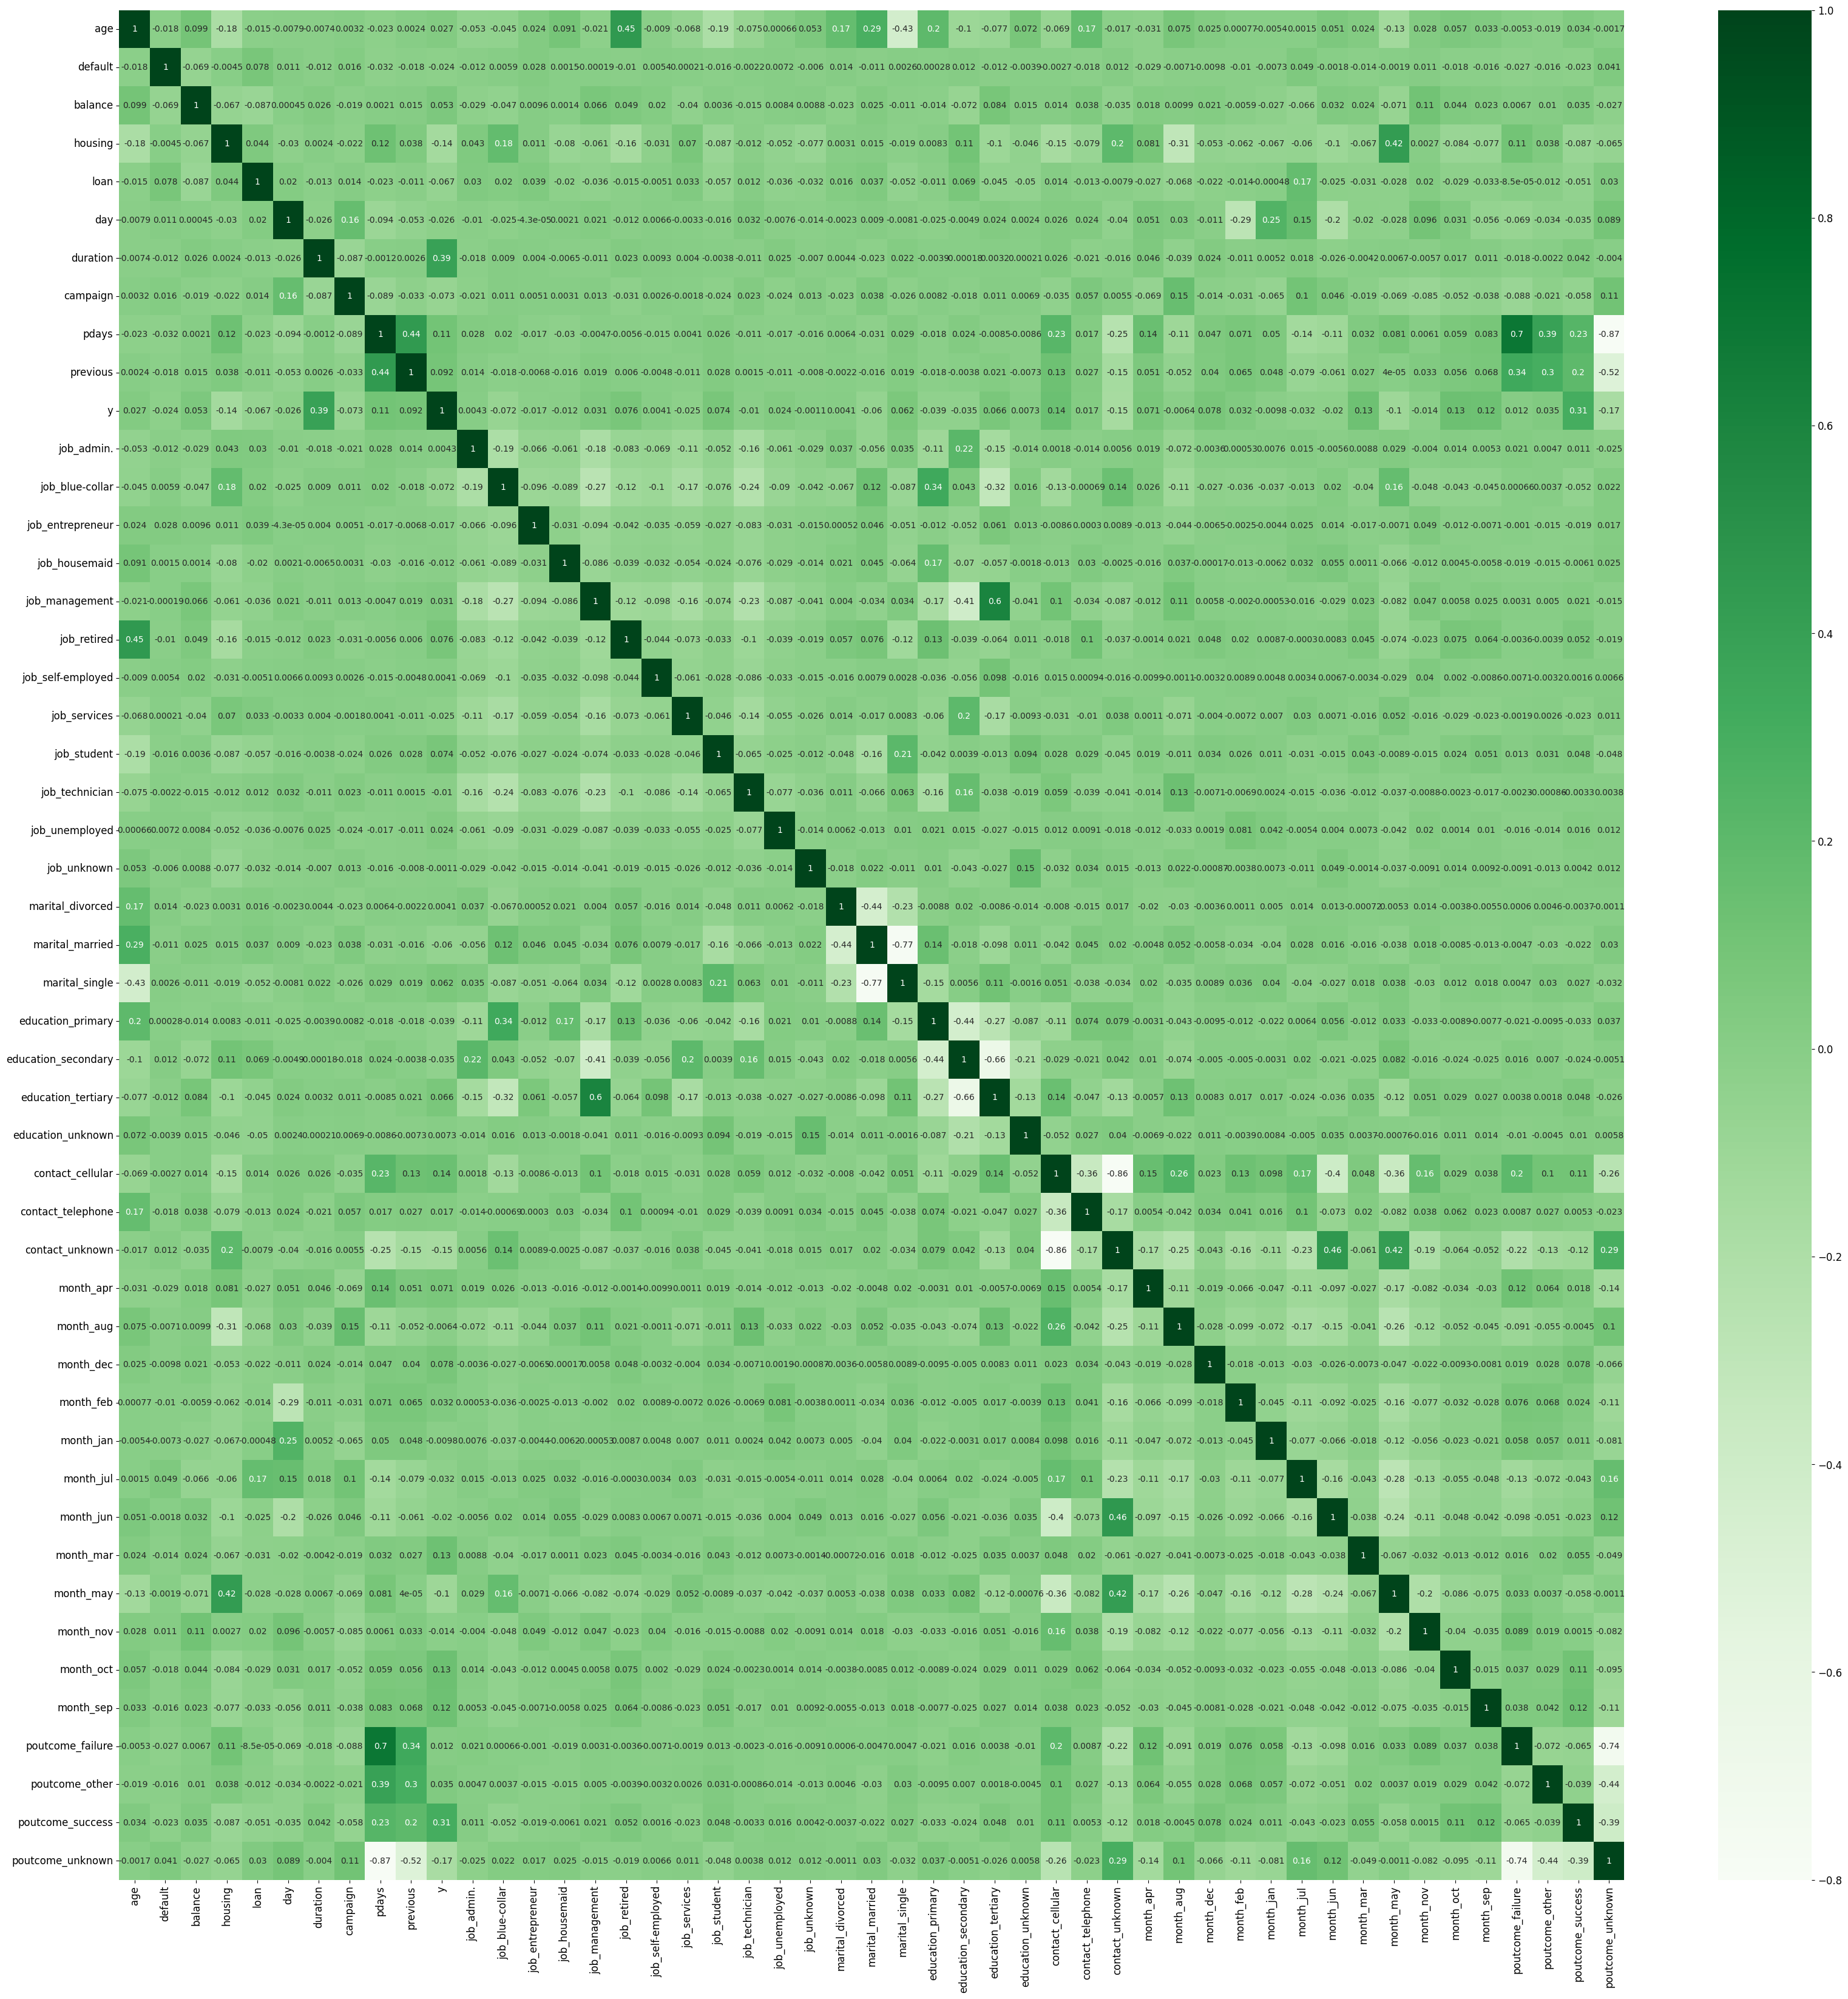

In [77]:
plt.figure(figsize=(40,40))
sns.heatmap(train_set.corr(),
           vmin=-0.8,
           vmax=1,
           cmap="Greens",
           annot=True);

La que mejor correla con "y" es duration.

Creo que se puede quitar poutcome_failure, job_retired y job_management.

In [78]:
train_set.drop(columns={"poutcome_failure", "job_retired", "job_management"}, inplace=True)
test_set.drop(columns={"poutcome_failure", "job_retired", "job_management"}, inplace=True)


Uso la funcion del team challenge para pintas plots

In [79]:
def plot_features_num_regression(df, target_col="", columns=[], umbral_corr=0, pvalue=None):
    """
    Crea un conjunto de pair plots para visualizar las correlaciones entre las columnas numéricas del DataFrame.

    Args:
        df: El DataFrame del que se quiere visualizar las correlaciones.
        target_col: El nombre de la columna objetivo.
        umbral_corr= numbral maximo establecido de correlacion con la target
        pvalue: El valor de p-valor.

    Returns:
        None
    """

    columnas_para_pintar = []
    columnas_umbral_mayor = []

    #iteramos por la columnas
    for col in columns:
        #si en la iteracion de las columnas del DF y siempre que...
        # se comprube si son numéricas(true) o no son numéricas(false)
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            # usando el indice de correlación de Pearson y el p-valor(funcion pearsonr)
            # calculamos dichos parametros para target y resto de columnas
            corr, pv = pearsonr(df[col], df[target_col])
            if abs(corr) > umbral_corr:
                columnas_umbral_mayor.append(col)
                if pvalue is None or pv < pvalue:
                    columnas_para_pintar.append(col)

    # Número máximo de gráficas por grupo
    max_graficas_por_grupo = 6

    # Dividir en grupos según el número máximo de gráficas
    len(columnas_para_pintar) // max_graficas_por_grupo
    # En un alista de comprension, iteramos en rango desde 0 hasta el numero de columnas a pintar, por cada grupo maximo establecido
    # creando graficas con columnas maxi de i+ grupo max establecido ( ejem: '0 hasta 0+6)
    columnas = [columnas_para_pintar[i:i+max_graficas_por_grupo] for i in range(0, len(columnas_para_pintar), max_graficas_por_grupo)]

    # iteramos por i y por valor 'umbral_corr' establecido a cada grupo en cada iteración,  creeando pair plots para cada grupo,
    for i, grupo in enumerate(columnas):
        sns.pairplot(df, vars=grupo, hue=target_col)
        plt.suptitle(f"Group {i}", y=1.02)# creo nombres de grupo un poco por encima de y, para que no se superponga con la gráfica
        plt.show()
    
    return "Las columnas con un mayor umbral_corr al establecido son", columnas_umbral_mayor

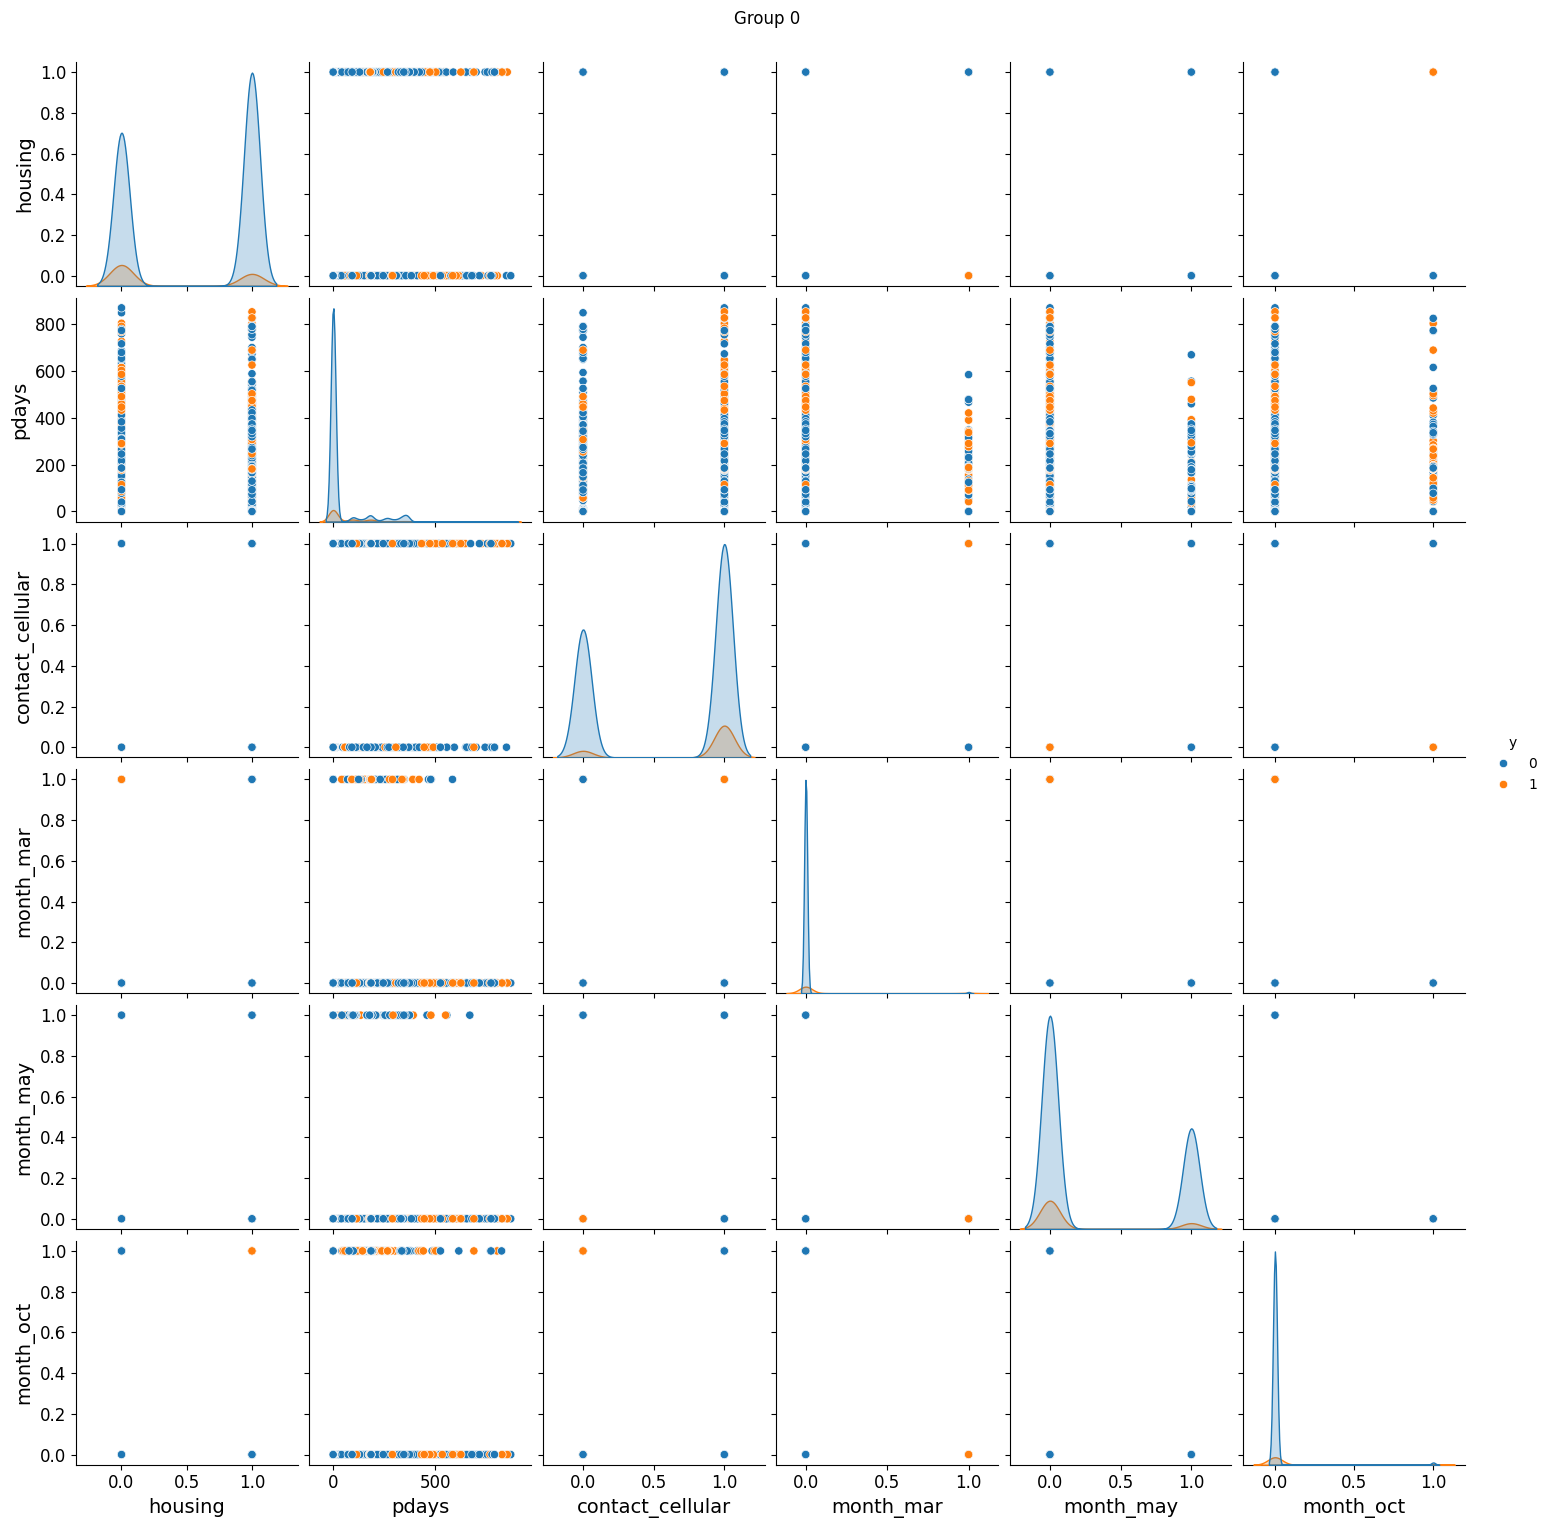

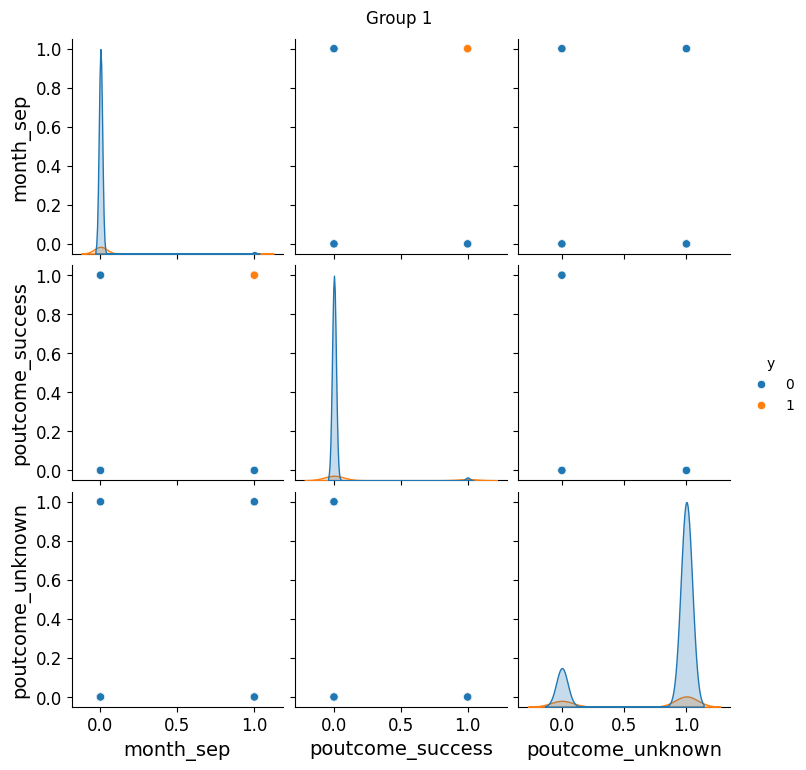

In [80]:
plot_features_num_regression(train_set, target_col="y", columns=['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign',
       'pdays', 'previous', 'previous', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'], umbral_corr=0.1, pvalue=None);

Ahora esta todo limpio puedo empezar con el modelo.

In [81]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

In [85]:
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7952
           1       0.48      0.50      0.49      1091

    accuracy                           0.88      9043
   macro avg       0.71      0.71      0.71      9043
weighted avg       0.88      0.88      0.88      9043



pruebo modificando hiperparametros

In [116]:
dtr2 = DecisionTreeClassifier(max_depth= 30, max_leaf_nodes= 50)

In [117]:
dtr2.fit(X_train, y_train)
y_pred = dtr2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7952
           1       0.62      0.42      0.50      1091

    accuracy                           0.90      9043
   macro avg       0.77      0.69      0.72      9043
weighted avg       0.89      0.90      0.89      9043



Mejora precision pero empeora recall, mejora accuracy.

In [121]:
tree_param_grid = {
    'max_depth': [None] + list(range(1, 11)),
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [2,4,8]
}



In [122]:
# RandomizedSearch para DecisionTreeClassifier
tree_random_search = RandomizedSearchCV(dtr, tree_param_grid, n_iter=25, cv=5, scoring='accuracy', random_state=42)
tree_random_search.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._sco

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=25,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [2, 4, 8]},
                   random_state=42, scoring='accuracy')

In [123]:
tree_random_search.best_params_

{'min_samples_split': 8, 'min_samples_leaf': 8, 'max_depth': 6}

In [124]:
tree_random_search.best_score_

nan

Con el de los hiperparametros:

In [126]:
# RandomizedSearch para DecisionTreeClassifier
tree_random_search = RandomizedSearchCV(dtr2, tree_param_grid, n_iter=25, cv=5, scoring='accuracy', random_state=42)
tree_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(max_depth=30,
                                                    max_leaf_nodes=50),
                   n_iter=25,
                   param_distributions={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [2, 4, 8]},
                   random_state=42, scoring='accuracy')

In [127]:
tree_random_search.best_params_

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}

In [128]:
tree_random_search.best_score_

0.9034782597394724

Me quedo con este ultimo.

In [129]:
# GridSearchCV para DecisionTreeClassifier

tree_grid_search = GridSearchCV(dtr2, tree_param_grid, cv=5, scoring='accuracy')
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=30, max_leaf_nodes=50),
             param_grid={'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 4, 8]},
             scoring='accuracy')

In [131]:
tree_grid_search.best_params_

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [132]:
tree_grid_search.best_score_

0.9034782597394724

No entiendo bien las diferencias.

Voy a comparar cn el de regresion logistica

In [135]:
lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [136]:
lr_param_grid = {
    'C': np.logspace(-4, 4, 20), # Una sugerencia posible. No es obligatorio hacerlo así. Si hace falta investiga que hace np.logspace
    'solver': ['liblinear', 'lbfgs'], 
    'max_iter': [10000,20000]
}

In [138]:
logistic_random_search = RandomizedSearchCV(lr, lr_param_grid, n_iter=2, cv=5, scoring='accuracy', random_state=42)
logistic_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=2,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'max_iter': [10000, 20000],
                                        'solver': ['liblinear', 'lbfgs']},
                   random_state=42, scoring='accuracy')

In [139]:
logistic_random_search.best_params_

{'solver': 'liblinear', 'max_iter': 20000, 'C': 0.08858667904100823}

In [140]:
logistic_random_search.best_score_

0.9014875909920589

Es un pelin peor

Pinto el arbol

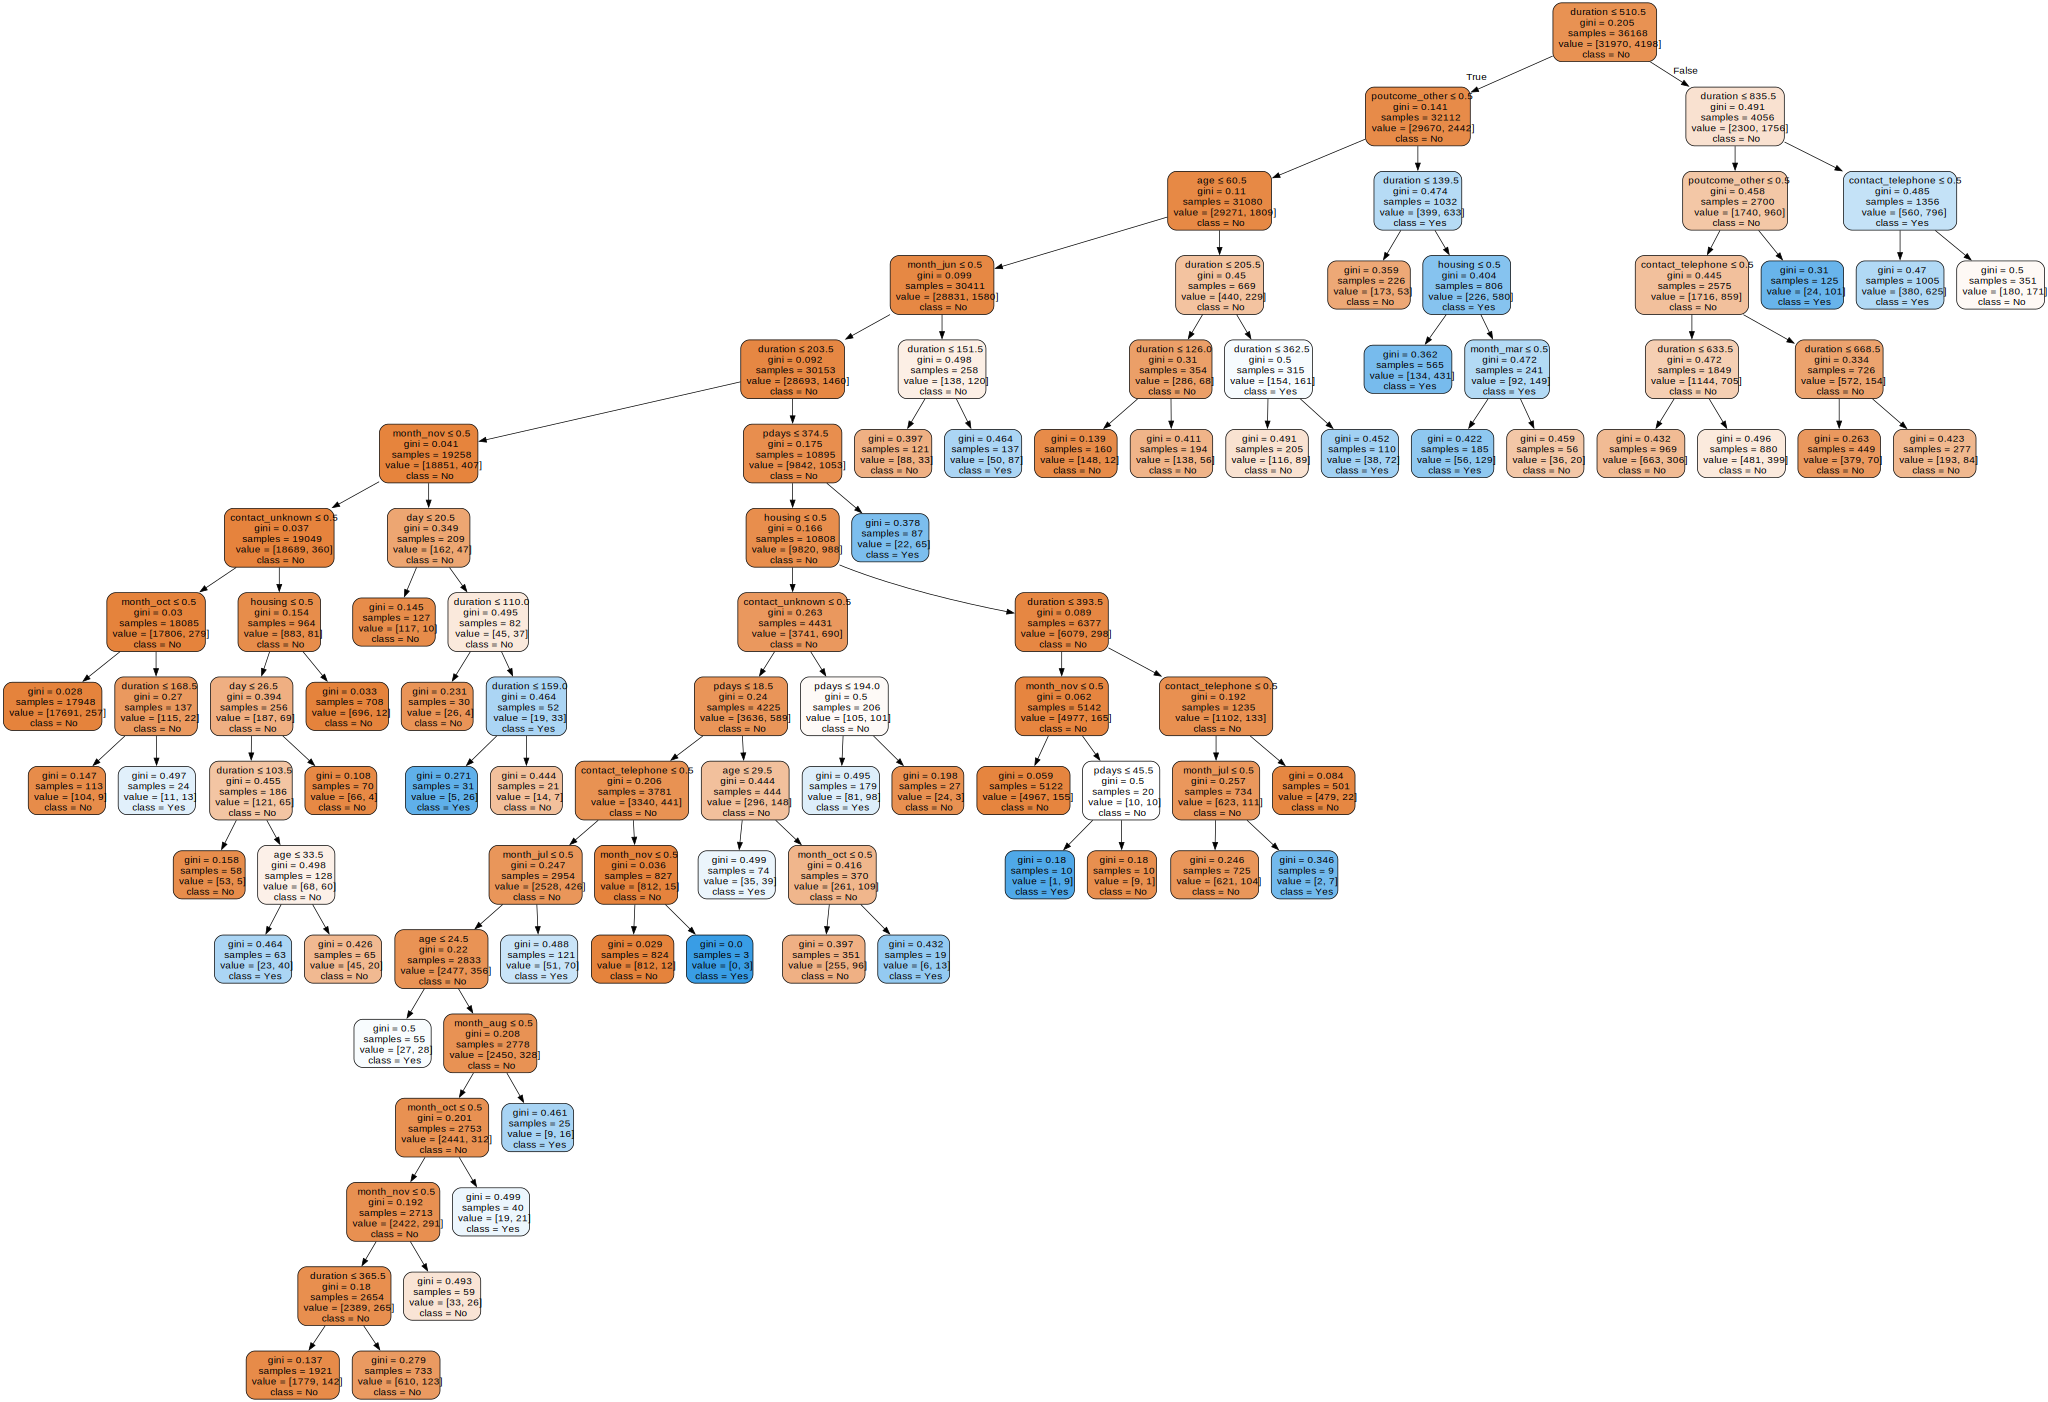

In [153]:
feature_names = bank_encoded.columns[:-1]  # Excluyendo la última columna que es la variable objetivo

dot_data = tree.export_graphviz(dtr2, out_file=None, 
                                feature_names=feature_names,
                                class_names=["No", "Yes"],
                                filled=True, rounded=True, special_characters=True,
                                max_depth=20)

graphviz.Source(dot_data)